In [1]:
import pandas as pd
import scipy
import numpy as np
from math import sin, cos, pi, atan2, asin, sqrt
import matplotlib.pyplot as plt
from scipy import integrate
import Helper_Functions as hf

In [9]:
################## CONSTANTS ##################
# gravity
g = 9.81  # m/s^2
# m to ft
ft = 3.2884  # ft/m

## 21 Full-scale

In [13]:
################## DATA FRAME ##################
datafile = '../Fullscale21.csv'
fields = ['Timestamp', 'Pres',
  'Roll', 'Pitch', 'Yaw',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  ]

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
all_time = df['Timestamp'].values

tdata = all_time
tdata = tdata - all_time[0]
L = tdata.shape[0]

In [11]:
ax_vn21 = df['LinearAccelNed X']* ft
ay_vn21 = df['LinearAccelNed Y']* ft
az_vn21 = df['LinearAccelNed Z']* -ft

ax_g21 = df['LinearAccelNed X']/9.8 #* ft
ay_g21 = df['LinearAccelNed Y']/9.8 #* ft
az_g21 = df['LinearAccelNed Z']/-9.8 #* -ft

In [ ]:
start21 = 625
end21 = 1000
tdata21 = tdata[start21:end21]
axg21t = list(ax_g21[start21:end21])


fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata21, ax_g21[start21:end21], color='red', label='x')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")

ax.legend()
plt.show()

In [37]:
def find_peak_and_wait(ax, t, thresh=70, delay=2):
    axn = np.array(ax)
    above_threshold = axn > thresh
    first_pass = list(above_threshold).index(True)
    print(f"First pass at index {first_pass} at time {t[first_pass]}")
    
    i = first_pass
    while t[i] < (t[first_pass] + 2):
        i += 1
        
    print(t[i])
    
find_peak_and_wait(np.array(axg21t)*9.8, tdata21)

First pass at index 1 at time 15.966999999999985
17.989000000000033


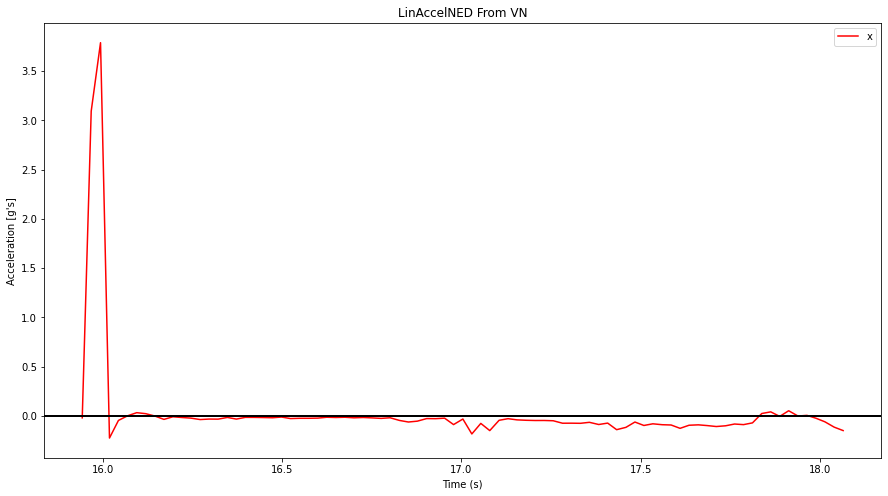

In [21]:
start21 = 630
end21 = 715
tdata21 = tdata[start21:end21]
axg21t = list(ax_g21[start21:end21])


fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata21, ax_g21[start21:end21], color='red', label='x')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")

ax.legend()
plt.show()

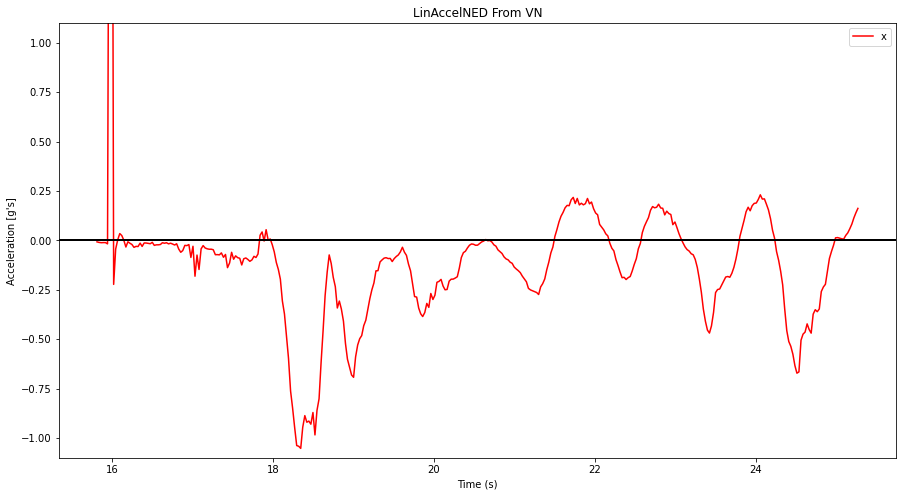

In [43]:
start21 = 625
end21 = 1000
tdata21 = tdata21[start21:end21]
axg21t = list(ax_g21[start21:end21])


fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata21, ax_g21[start21:end21], color='red', label='x')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
plt.ylim((-1.1, 1.1))

ax.legend()
plt.show()

In [135]:
#calculate moving average

def calc_moving_avg(axg21t, n, tdata21, dynamic_window=False, dynamic_n_timing=140, dynamic_n=80):        
    if dynamic_window:
        axg21s_1 = pd.Series(axg21t[0:dynamic_n_timing]).rolling(window=n).mean().iloc[n-1:].values
        axg21s_2 = pd.Series(axg21t).rolling(window=dynamic_n).mean().iloc[n-1:].values[dynamic_n_timing:]
        new_axg21s = list(axg21s_1) + list(axg21s_2)
    else:
        axg21s = pd.Series(axg21t).rolling(window=n).mean().iloc[n-1:].values
        new_axg21s = list(axg21s)
    #zero_padding_size = (len(tdata21) - len(new_axg21s)) // 2
    #for i in range(zero_padding_size):
    #    new_axg21s = [0] + list(new_axg21s) + [0]
    while len(new_axg21s) < len(tdata21):
        new_axg21s = [0] + list(new_axg21s) + [0]
    return new_axg21s

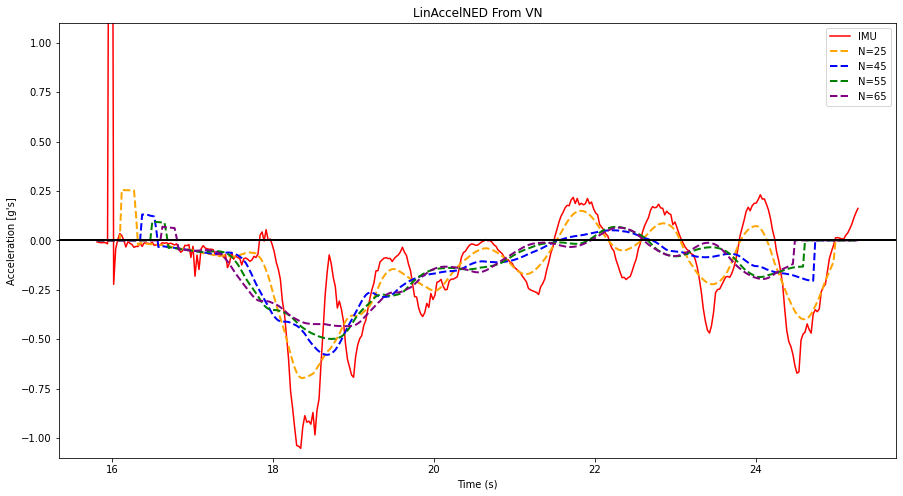

Estimated Wind Speed via Original IMU Signal: -0.00008790 m/s
Estimated Wind Speed via Moving Average: -0.00009388 m/s


In [136]:
#calculate moving average
new_axg21s_25 = calc_moving_avg(axg21t, 25, tdata21)
new_axg21s_45 = calc_moving_avg(axg21t, 45, tdata21)
new_axg21s_55 = calc_moving_avg(axg21t, 55, tdata21)
new_axg21s_65 = calc_moving_avg(axg21t, 65, tdata21)

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata21, axg21t, color='red', label='IMU')
l25 = ax.plot(tdata21, new_axg21s_25, color='orange', label='N=25', linewidth=2, linestyle="--")
l45 = ax.plot(tdata21, new_axg21s_45, color='blue', label='N=45', linewidth=2, linestyle="--")
l55 = ax.plot(tdata21, new_axg21s_55, color='green', label='N=55', linewidth=2, linestyle="--")
l65 = ax.plot(tdata21, new_axg21s_65, color='purple', label='N=65', linewidth=2, linestyle="--")
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
plt.ylim((-1.1, 1.1))

ax.legend()
plt.show()

result_trapz_IMU = scipy.integrate.trapz(axg21t, dx=0.2E-6)
result_trapz_MA = scipy.integrate.trapz(new_axg21s, dx=0.2E-6)

print(f"Estimated Wind Speed via Original IMU Signal: {9.8*result_trapz_IMU:.8f} m/s")
print(f"Estimated Wind Speed via Moving Average: {9.8*result_trapz_MA:.8f} m/s")

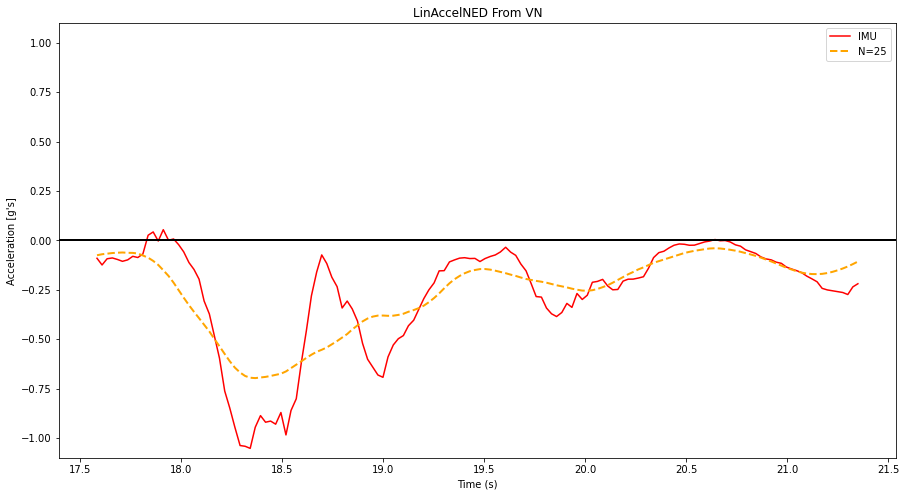

Estimated Wind Speed via Original IMU Signal: 0.00007837 m/s
Estimated Wind Speed via Original IMU Signal: 3.867 m/s
-------------------------------------------------------------------
Estimated Wind Speed via Moving Average: 0.00008241 m/s
Estimated Wind Speed via Moving Average: 2.561 m/s


In [118]:
sta = 70
rt = 220

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata21[sta:rt], axg21t[sta:rt], color='red', label='IMU')
l25 = ax.plot(tdata21[sta:rt], new_axg21s_25[sta:rt], color='orange', label='N=25', linewidth=2, linestyle="--")
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
plt.ylim((-1.1, 1.1))

ax.legend()
plt.show()

ax21 = [abs(ele)*9.8 for ele in axg21t[sta:rt]]
new_ax21 = [abs(ele)*9.8 for ele in new_axg21s[sta:rt]]

result_trapz_IMU = scipy.integrate.trapz(ax21, dx=0.2E-6)
result_trapz_MA = scipy.integrate.trapz(new_ax21, dx=0.2E-6)

print(f"Estimated Wind Speed via Original IMU Signal: {result_trapz_IMU:.8f} m/s")
print(f"Estimated Wind Speed via Original IMU Signal: {max(ax21)*1.5/2/2:.3f} m/s")
print("-------------------------------------------------------------------")
print(f"Estimated Wind Speed via Moving Average: {result_trapz_MA:.8f} m/s")
print(f"Estimated Wind Speed via Moving Average: {max(new_ax21)*1.5/2/2:.3f} m/s")

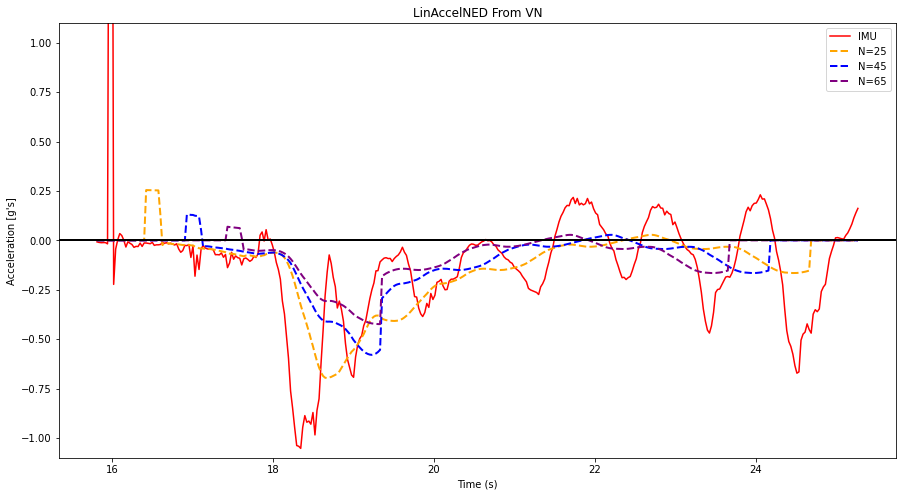

Estimated Wind Speed via Original IMU Signal: 0.00007837 m/s
Inspected Wind Speed via Original IMU Signal: 3.867 m/s
-------------------------------------------------------------------
Inspected Wind Speed via Moving Average (25): 2.561 m/s
Estimated Wind Speed via Moving Average (25): 0.00003091 m/s
Inspected Wind Speed via Moving Average (45): 2.561 m/s
Estimated Wind Speed via Moving Average (45): 0.00003091 m/s
Inspected Wind Speed via Moving Average (65): 2.561 m/s
Estimated Wind Speed via Moving Average (65): 0.00003091 m/s


In [139]:
#calculate moving average
new_axg21s_25 = calc_moving_avg(axg21t, 25, tdata21, True)
new_axg21s_45 = calc_moving_avg(axg21t, 45, tdata21, True)
#new_axg21s_55 = calc_moving_avg(axg21t, 55, tdata21, True)
new_axg21s_65 = calc_moving_avg(axg21t, 65, tdata21, True)

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata21, axg21t, color='red', label='IMU')
l25 = ax.plot(tdata21, new_axg21s_25, color='orange', label='N=25', linewidth=2, linestyle="--")
l45 = ax.plot(tdata21, new_axg21s_45, color='blue', label='N=45', linewidth=2, linestyle="--")
#l55 = ax.plot(tdata21, new_axg21s_55, color='green', label='N=55', linewidth=2, linestyle="--")
l65 = ax.plot(tdata21, new_axg21s_65, color='purple', label='N=65', linewidth=2, linestyle="--")
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
plt.ylim((-1.1, 1.1))

ax.legend()
plt.show()

ax21 = [abs(ele)*9.8 for ele in axg21t[sta:rt]]
new_ax21_25 = [abs(ele)*9.8 for ele in new_axg21s[sta:rt]]
new_ax21_45 = [abs(ele)*9.8 for ele in new_axg21s[sta:rt]]
new_ax21_65 = [abs(ele)*9.8 for ele in new_axg21s[sta:rt]]

result_trapz_IMU = scipy.integrate.trapz(ax21, dx=0.2E-6)
result_trapz_MA_25 = scipy.integrate.trapz(new_ax21_25, dx=0.2E-6)
result_trapz_MA_45 = scipy.integrate.trapz(new_ax21_45, dx=0.2E-6)
result_trapz_MA_65 = scipy.integrate.trapz(new_ax21_65, dx=0.2E-6)

print(f"Estimated Wind Speed via Original IMU Signal: {result_trapz_IMU:.8f} m/s")
print(f"Inspected Wind Speed via Original IMU Signal: {max(ax21)*1.5/2/2:.3f} m/s")
print("-------------------------------------------------------------------")
print(f"Inspected Wind Speed via Moving Average (25): {max(new_ax21_25)*1.5/2/2:.3f} m/s")
print(f"Estimated Wind Speed via Moving Average (25): {(result_trapz_MA_25)*1.5/2/2:.8f} m/s")
print(f"Inspected Wind Speed via Moving Average (45): {max(new_ax21_45)*1.5/2/2:.3f} m/s")
print(f"Estimated Wind Speed via Moving Average (45): {(result_trapz_MA_45)*1.5/2/2:.8f} m/s")
print(f"Inspected Wind Speed via Moving Average (65): {max(new_ax21_65)*1.5/2/2:.3f} m/s")
print(f"Estimated Wind Speed via Moving Average (65): {(result_trapz_MA_65)*1.5/2/2:.8f} m/s")

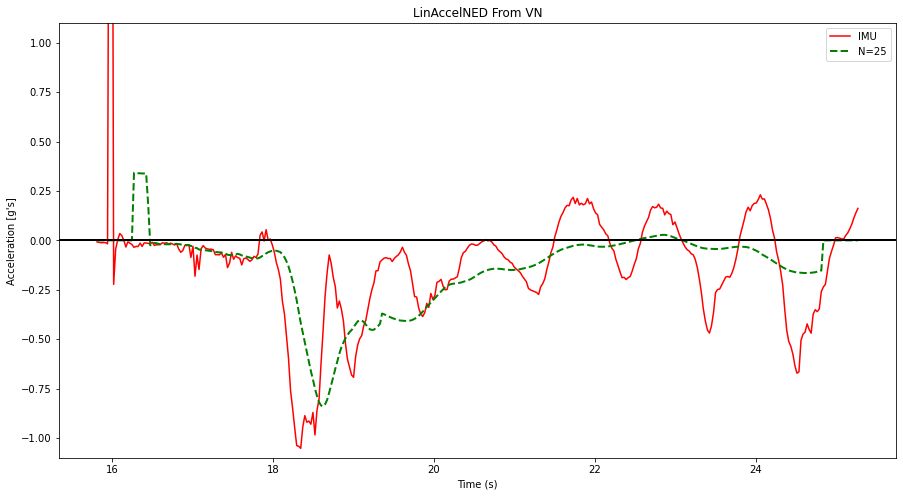

In [144]:
new_axg21s_15 = calc_moving_avg(axg21t, 19, tdata21, True)

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata21, axg21t, color='red', label='IMU')
l25 = ax.plot(tdata21, new_axg21s_15, color='green', label='N=25', linewidth=2, linestyle="--")
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
plt.ylim((-1.1, 1.1))

ax.legend()
plt.show()

## Y Direction

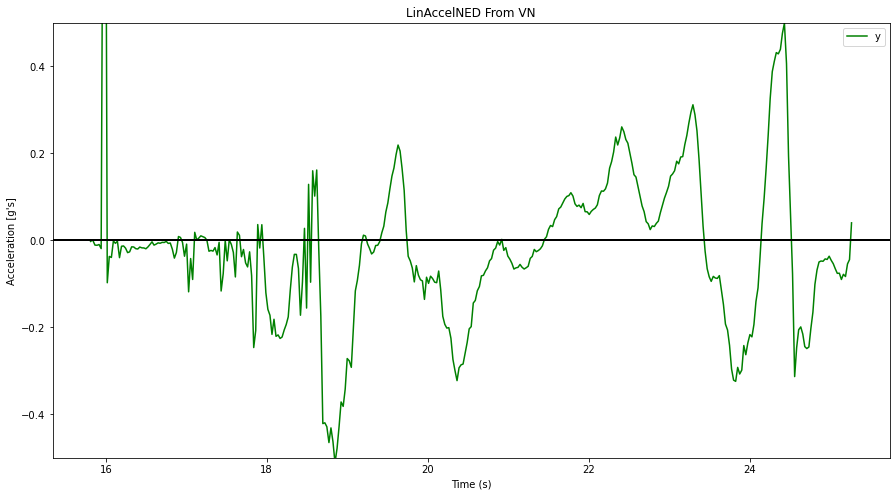

In [14]:
fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata21, ay_g21[start21:end21], color='green', label='y')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
plt.ylim((-0.5, 0.5))

ax.legend()
plt.show()

In [63]:
ayg21t = ay_g21[start21:end21]

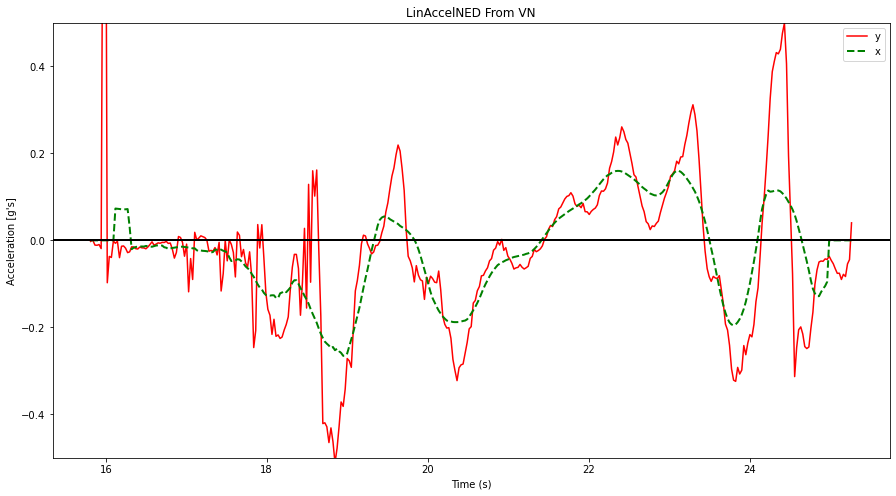

In [64]:
n=25

#calculate moving average
ayg21s = pd.Series(ayg21t).rolling(window=n).mean().iloc[n-1:].values
new_ayg21s = list(ayg21s)
zero_padding_size = (len(tdata21) - len(list(ayg21s))) // 2
for i in range(zero_padding_size):
    new_ayg21s = [0] + list(new_ayg21s) + [0]
while len(new_ayg21s) < len(tdata21):
    new_ayg21s = [0] + new_ayg21s
    
fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata21, ay_g21[start21:end21], color='red', label='y')
l2 = ax.plot(tdata21, new_ayg21s, color='green', label='x', linewidth=2, linestyle="--")
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
plt.ylim((-0.5, 0.5))

ax.legend()
plt.show()

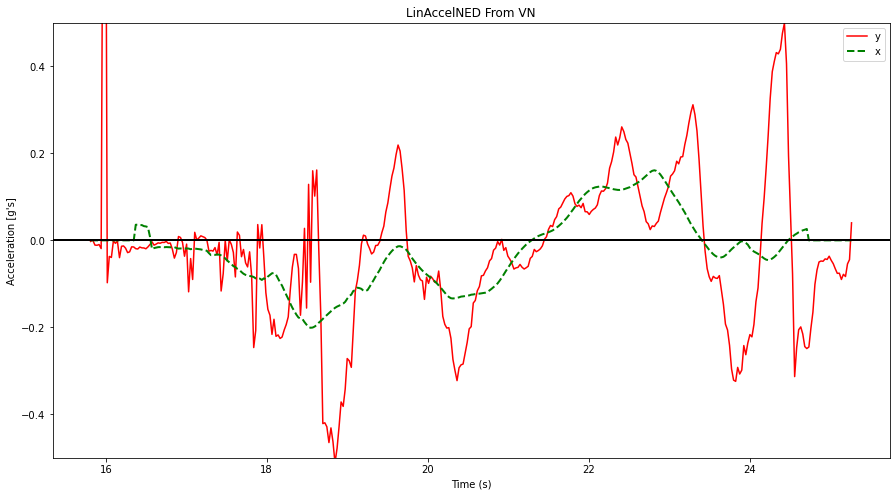

In [67]:
n=45

#calculate moving average
ayg21s = pd.Series(ayg21t).rolling(window=n).mean().iloc[n-1:].values
new_ayg21s = list(ayg21s)
zero_padding_size = (len(tdata21) - len(list(ayg21s))) // 2
for i in range(zero_padding_size):
    new_ayg21s = [0] + list(new_ayg21s) + [0]
while len(new_ayg21s) < len(tdata21):
    new_ayg21s = [0] + new_ayg21s
    
fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata21, ay_g21[start21:end21], color='red', label='y')
l2 = ax.plot(tdata21, new_ayg21s, color='green', label='x', linewidth=2, linestyle="--")
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
plt.ylim((-0.5, 0.5))

ax.legend()
plt.show()

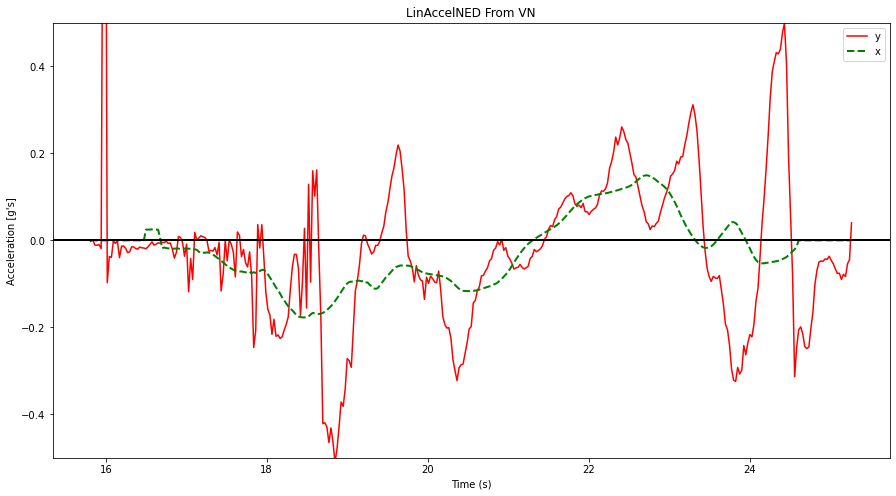

In [66]:
n=55

#calculate moving average
ayg21s = pd.Series(ayg21t).rolling(window=n).mean().iloc[n-1:].values
new_ayg21s = list(ayg21s)
zero_padding_size = (len(tdata21) - len(list(ayg21s))) // 2
for i in range(zero_padding_size):
    new_ayg21s = [0] + list(new_ayg21s) + [0]
while len(new_ayg21s) < len(tdata21):
    new_ayg21s = [0] + new_ayg21s
    
fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata21, ay_g21[start21:end21], color='red', label='y')
l2 = ax.plot(tdata21, new_ayg21s, color='green', label='x', linewidth=2, linestyle="--")
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
plt.ylim((-0.5, 0.5))

ax.legend()
plt.show()

# 22 Full-Scale

In [128]:
################## DATA FRAME ##################
datafile = '../Data/Trunc_Fullscale1.csv'
fields = ['Timestamp', 'Pres',
  'Roll', 'Pitch', 'Yaw',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  ]

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
all_time = df['Timestamp'].values

tdata = all_time
tdata = tdata - all_time[0]
L = tdata.shape[0]

ax_vn = df['LinearAccelNed X']* ft
ay_vn = df['LinearAccelNed Y']* ft
az_vn = df['LinearAccelNed Z']* -ft

ax_g22 = df['LinearAccelNed X']/9.8 #* ft
ay_g22 = df['LinearAccelNed Y']/9.8 #* ft
az_g22 = df['LinearAccelNed Z']/-9.8 #* -ft

axg22t = list(ax_g22)
start22 = 670
end22 = 1000
tdata22 = tdata[start22:end22]
axg22t = ax_g22[start22:end22]

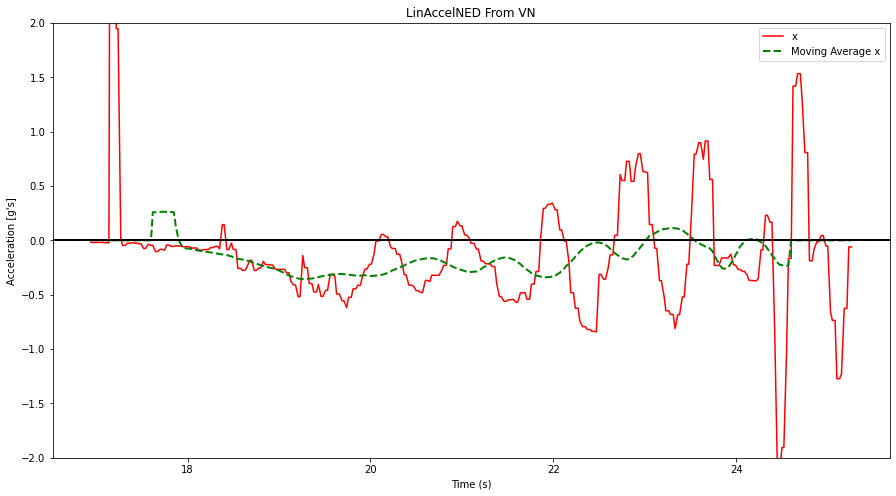

Estimated Wind Speed via Original IMU Signal: -0.00007448 m/s
Estimated Wind Speed via Moving Average: -0.00008643 m/s
Estimated Wind Speed via Original, Zoomed In: -0.00007306 m/s


In [131]:
n=55

#calculate moving average
axg22s = pd.Series(axg22t).rolling(window=n).mean().iloc[n-1:].values
new_axg22s = list(axg22s)
zero_padding_size = (len(tdata22) - len(list(axg22s))) // 2
for i in range(zero_padding_size):
    new_axg22s = [0] + list(new_axg22s) + [0]
while len(new_axg22s) < len(tdata22):
    new_axg22s = [0] + new_axg22s

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l1 = ax.plot(tdata22, ax_g22[start22:end22], color='red', label='x')
l2 = ax.plot(tdata22, new_axg22s, color='green', label='Moving Average x', linewidth=2, linestyle="--")
l2 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
plt.ylim((-2, 2))

ax.legend()
plt.show()

result_trapz_IMU = scipy.integrate.trapz(ax_g22[start22:end22], dx=0.2E-6)
result_trapz_MA = scipy.integrate.trapz(new_axg22s, dx=0.2E-6)
result_trapz_ZOOM = scipy.integrate.trapz(axg22t[75:280], dx=0.2E-6)

print(f"Estimated Wind Speed via Original IMU Signal: {9.8*result_trapz_IMU:.8f} m/s")
print(f"Estimated Wind Speed via Moving Average: {9.8*result_trapz_MA:.8f} m/s")
print(f"Estimated Wind Speed via Original, Zoomed In: {9.8*result_trapz_ZOOM:.8f} m/s")

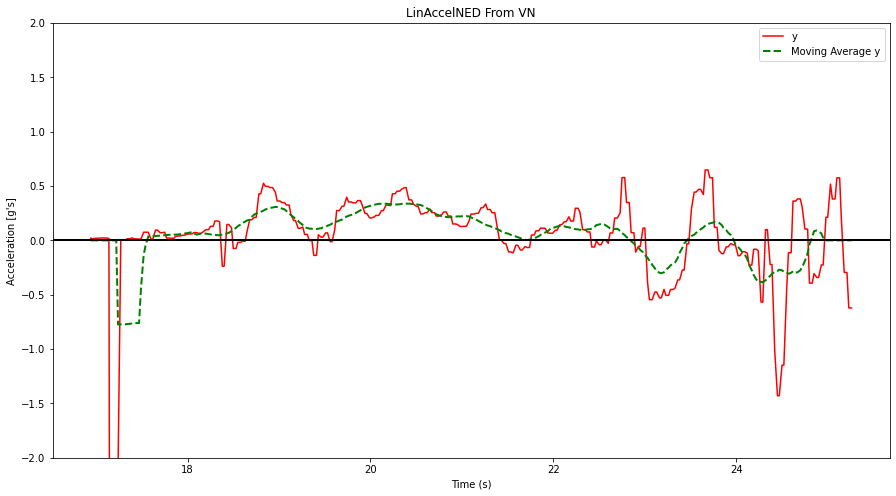

In [132]:
ayg22t = ay_g22[start22:end22]

n=25

#calculate moving average
ayg22s = pd.Series(ayg22t).rolling(window=n).mean().iloc[n-1:].values
new_ayg22s = list(ayg22s)
zero_padding_size = (len(tdata22) - len(list(ayg22s))) // 2
for i in range(zero_padding_size):
    new_ayg22s = [0] + list(new_ayg22s) + [0]
while len(new_ayg22s) < len(tdata22):
    new_ayg22s = [0] + new_ayg22s
    
fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l1 = ax.plot(tdata22, ay_g22[start22:end22], color='red', label='y')
l2 = ax.plot(tdata22, new_ayg22s, color='green', label='Moving Average y', linewidth=2, linestyle="--")
l2 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
plt.ylim((-2, 2))

ax.legend()
plt.show()